## Cross-validation and test error

In the following, we explain and analyse properties of 10-fold cross-validation. Similar analysis can be carried out for any other cross-validation type.  

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from pandas import Series
from pandas import DataFrame

from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Experiment setup

We again consider a relatively simple prediction task with a relatively small feature set and an impossible prediction task with the same feature set for comparison. 
We use majority voting and logistic regression as example classifiers as in the previous notebook. 

In [2]:
sampler_0 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([0, 0])))
sampler_1 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([1, 1])))
clf_1 = MajorityVoting()
clf_2 = LogisticRegression(solver = 'lbfgs')

## II. Naive implementation of cross-validation

The simplest way to implement a cross-validation is to first randomly shuffle the rows of the data frame and then split the data into consecutive folds.

### Random shuffle

According to [stackowerflow.com](https://stackoverflow.com/questions/15772009/shuffling-permutating-a-dataframe-in-pandas/35784666), there are at least three ways how to implement a random shuffle:

* permute the index of a data frame with `np.random.permutation`
* resample all of the data frame rows without replacement with `df.sample(frac=1)`
* rely on `sklearn.utils.shuffle` primitive

All of them lead to the same result. To fix your random choices, you can set `np.random.seed` with a unique random seed value. The safest way to choose the seed value is to fetch the current seed value, see [stackoverflow.com](https://stackoverflow.com/questions/32172054/how-can-i-retrieve-the-current-seed-of-numpys-random-number-generator) for further details.

However, getting the entire state and inlining it is too complex. It is enough if you just get a reasonable seed.  

In [3]:
# Initialise randomness and print out a random seed
np.random.seed()
print(np.random.randint(0, np.iinfo(np.int32).max))

# Use the printout as a random seed
np.random.seed(1351430195)
df = DataFrame({'a': [1,2,3], 'b': [4, 5, 6], 'c': [7, 8, 9]})

# Three alternatives for shuffle
mdisplay([
    df.reindex(np.random.permutation(df.index)),
    df.sample(frac=1),
    sklearn.utils.shuffle(df)
], ['nympy', 'pandas', 'sklearn'])

# Let's release the random seed 
random.seed()

1938513708


nympy,pandas,sklearn
a,b,c
1,4,7
3,6,9
2,5,8
a,b,c
3,6,9
2,5,8
1,4,7
a,b,c
1,4,7


### Naive data decomposition

* We fix the dataset size and parameters.
* We show how the cross-validation is implemented on an example data without initial shuffle.

In [4]:
k = 10
m = 10
n = k * m
data = sampler_0(n)
features = list(data.columns.values[:-1])

Let's compute the start and end indices for folds in terms of `iloc` numeration.

In [5]:
breaks = list(range(0, n, m))
print([(start, start + m) for start in breaks])

[(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]


* Now that we know what are the fold borders, we can define 10 data frames and implement cross-validation using these data frames. 
* In practice, you could do this much more efficiently using methods from `sklearn.model_selection`.

In [6]:
folds = [data.iloc[start: start + m] for start in range(0, n, m)]
mdisplay([folds[0].reset_index(), folds[9].reset_index()], ['Fold 1', 'Fold 10'])     

Fold 1 Fold 10 
 
 
 index 
 x_1 
 x_2 
 x_3 
 x_4 
 x_5 
 x_6 
 x_7 
 x_8 
 y 
 
 
 
 
 0 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 True 
 
 
 1 
 False 
 False 
 True 
 True 
 False 
 False 
 False 
 False 
 True 
 
 
 2 
 True 
 True 
 True 
 False 
 True 
 True 
 False 
 True 
 True 
 
 
 3 
 False 
 True 
 True 
 True 
 False 
 True 
 False 
 False 
 False 
 
 
 4 
 False 
 True 
 False 
 True 
 True 
 True 
 False 
 False 
 True 
 
 
 5 
 False 
 True 
 True 
 False 
 True 
 False 
 True 
 True 
 False 
 
 
 6 
 False 
 True 
 True 
 False 
 False 
 True 
 False 
 True 
 False 
 
 
 7 
 True 
 False 
 True 
 True 
 False 
 True 
 True 
 False 
 True 
 
 
 8 
 True 
 False 
 True 
 False 
 False 
 False 
 True 
 True 
 True 
 
 
 9 
 True 
 True 
 True 
 False 
 True 
 True 
 True 
 False 
 True 
 
 
 
 
 
 index 
 x_1 
 x_2 
 x_3 
 x_4 
 x_5 
 x_6 
 x_7 
 x_8 
 y 
 
 
 
 
 90 
 False 
 False 
 False 
 False 
 True 
 False 
 True 
 True 
 True 
 
 
 91 
 True 
 False 
 True 
 False 
 False 
 True 
 False 
 False 
 False 
 
 
 92 
 False 
 False 
 False 
 True 
 True 
 True 
 True 
 False 
 True 
 
 
 93 
 False 
 False 
 True 
 True 
 True 
 False 
 False 
 True 
 True 
 
 
 94 
 True 
 False 
 True 
 False 
 True 
 True 
 True 
 True 
 False 
 
 
 95 
 True 
 False 
 True 
 False 
 True 
 True 
 False 
 True 
 False 
 
 
 96 
 False 
 True 
 False 
 False 
 False 
 False 
 True 
 False 
 True 
 
 
 97 
 False 
 True 
 False 
 True 
 True 
 True 
 False 
 True 
 True 
 
 
 98 
 True 
 True 
 False 
 False 
 False 
 True 
 False 
 True 
 True 
 
 
 99 
 True 
 False 
 False 
 False 
 True 
 True 
 False 
 False 
 True

### Cross-validation loop and data gathering

In [7]:
cv_result = DataFrame(np.full([k, 2], np.nan), columns = ['training_error', 'test_error'])

for i in range(k):
    test = folds[i]
    training_index = [x for x in range(k) if x != i]
    train = pd.concat([folds[i] for i in training_index])
    
    clf_1.fit(train[features], train['y'])
    cv_result.loc[i, 'training_error'] = empirical_risk(clf_1, train[features], train['y'])
    cv_result.loc[i, 'test_error'] = empirical_risk(clf_1, test[features], test['y'])

cv_result['optimism'] = cv_result['test_error'] - cv_result['training_error']    
display(cv_result)        

,training_error,test_error,optimism
0,7.777778,30.0,22.222222
1,6.666667,70.0,63.333333
2,6.666667,80.0,73.333333
3,8.888889,60.0,51.111111
4,6.666667,40.0,33.333333
5,6.666667,60.0,53.333333
6,7.777778,50.0,42.222222
7,6.666667,50.0,43.333333
8,8.888889,60.0,51.111111
9,7.777778,40.0,32.222222


### Naive error bounds with moment matching 

As we have 10 observations, we can use moment matching to derive confidence intervals:
1. We estimate mean and variance for each parameter.
*  We find a normal distribution matching mean and variance.
*  We find approximate confidence intervals based on the normal distribution.

Resulting confidence intervals **will** most probably **underestimate the real variability** but are good enough in practice. 

In [8]:
moments = cv_result.apply(['mean', 'std']).T
display(moments)
moments = (moments
           .assign(lower_ci = stats.norm.ppf(0.025, loc = moments['mean'] , scale = moments['std']/np.sqrt(10)))
           .assign(upper_ci = stats.norm.ppf(0.975, loc = moments['mean'] , scale = moments['std']/np.sqrt(10)))
           .reset_index().rename(columns = {'index': 'measure'})
          [['measure', 'mean', 'lower_ci', 'upper_ci', 'std']])
display(moments)

,mean,std
training_error,7.444444,0.914747
test_error,54.000000,15.055453
optimism,46.555556,15.229835


,measure,mean,lower_ci,upper_ci,std
0,training_error,7.444444,6.877489,8.011400,0.914747
1,test_error,54.000000,44.668705,63.331295,15.055453
2,optimism,46.555556,37.116179,55.994932,15.229835


In [9]:
df = cv_result.stack().reset_index(1).rename(columns = {'level_1': 'measure', 0: 'value'})

In [10]:
p = ggplot(df)
p = p + geom_jitter(aes(x = 'measure', y = 'value'), width = 0.04, alpha = 0.5)
p = p + geom_errorbar(aes(x = 'measure', ymin = 'lower_ci', ymax = 'upper_ci'), color = 'red', width = 0.2, data = moments)
p = p + geom_point(aes(x = 'measure', y = 'mean'), size =  3, color = 'blue', data = moments)
p = p + scale_x_discrete(name = '')
p.save('crossvalidation_moment_matching.pdf', path='results', height=6, width=6, verbose=False)
display()

### Formalisation as a function

In [11]:
def crossvalidation(X: DataFrame, y: Series, clf, k: int=10):
    assert len(X) == len(y), 'Data matrix and the target vector must match'
    assert len(X) % k == 0,  'Crossvalidation is unimplemented for cases n != k * m'  
    assert X.index.equals(y.index), 'Indices of the data matrix and target vector must match'

    n = len(X)
    m = int(n/k)
    samples = np.random.permutation(X.index)
    folds = [samples[start: start + m] for start in range(0, n, m)]
    result = (combine_categories({'run': range(10),'measure':['training error', 'test error', 'optimism']})
              .assign(value = np.nan)
              .set_index(['run', 'measure'])
              .sort_index())
    
    for i in range(k):
        training_index = [x for x in range(k) if x != i]
        training_samples = np.concatenate([folds[i] for i in training_index])
        test_samples = folds[i]
     
        clf.fit(X.iloc[training_samples], y.iloc[training_samples])
        
        result.loc[(i, 'training error'), 'value'] = empirical_risk(clf, X.iloc[training_samples], y.iloc[training_samples])
        result.loc[(i, 'test error'), 'value'] = empirical_risk(clf, X.iloc[test_samples], y.iloc[test_samples])
        result.loc[(i, 'optimism'), 'value'] =  result.loc[(i, 'test error'), 'value'] - result.loc[(i, 'training error'), 'value'] 
    
    return result.reset_index()

In [12]:
result = crossvalidation(data[features], data['y'], clf_1)
moments = result.groupby('measure').aggregate({'value': ['mean', 'std']})
moments.columns = moments.columns.droplevel(0)
moments = moments.reset_index()
display(moments)

,measure,mean,std
0,optimism,48.666667,14.664048
1,test error,56.000000,14.298407
2,training error,7.333333,1.304209


## III. Experimental comparison with hold-out  testing

Although 10-fold cross-validaton creates 10 different runs, these runs are not independent as they share a lot of the training data. As a consequence the estimates on average training and test errors might be biased comapred to hold-out testing.

The following experiment is set to fairly compare cross-validation and hold-out testing:

* We generate many datasets of a fixed size $n$. 
* For each dataset, we generate complementary test set of the same size $n$.

Next, we consider three strategies for computing test and training errors:

* We use 10-fold cross-validation on the dataset.
* We use 9-folds to train the model and estimate test error on the hold-out test set.
* We use 10-folds to train the model and estimate test error on the hold-out test set. 

The first two experiments should have the same expected training error:
* In both cases, models are trained on 9 folds.
* In both cases, test set elements are independent from the training set elements.

The third model should have a slightly lower test error compared to the second model since the training set is larger. 

### Configuration 

In [13]:
r = 500
n = 100
features = list(sampler_0(1).columns.values[:-1])
clf_1 = MajorityVoting()
clf_2 = LogisticRegression(solver = 'lbfgs')

# Data frame for storing results 
result = (combine_categories({'method': ['crossvalidation','9-fold holdout', '10-fold holdout'], 
                               'measure': ['training error', 'test error', 'optimism'],
                               'run': list(range(r))})
           .assign(mean = np.nan, std = np.nan)
           .set_index(['method', 'measure', 'run'])
           .sort_index())
display(result.head())

mean  std
method          measure  run           
10-fold holdout optimism 0     NaN  NaN
                         1     NaN  NaN
                         2     NaN  NaN
                         3     NaN  NaN
                         4     NaN  NaN

### Experiment

In [14]:
for i in trange(r, desc = 'Simulation'):
    data = sampler_1(n)
    holdout_data = sampler_1(n)
    
    cv_result = (crossvalidation(data[features], data['y'], clf_2).groupby(['measure'])
                 .aggregate({'value': ['mean', 'std']})
                 .pipe(reset_column_index, 0))

    result.loc[('crossvalidation', 'training error', i), :] = cv_result.loc['training error']
    result.loc[('crossvalidation', 'test error',     i), :] = cv_result.loc['test error']
    result.loc[('crossvalidation', 'optimism',       i), :] = cv_result.loc['optimism']
    
    # 9-fold experiment
    samples = np.random.permutation(data.index)[:int(0.9*n)]
    clf_2.fit(data[features].iloc[samples], data['y'].iloc[samples])
    result.loc[('9-fold holdout', 'training error', i), 'mean'] = empirical_risk(clf_2, data[features].iloc[samples], data['y'].iloc[samples])
    result.loc[('9-fold holdout', 'test error',     i), 'mean'] = empirical_risk(clf_2, holdout_data[features], holdout_data['y'])
    result.loc[('9-fold holdout', 'optimism',       i), 'mean'] = result.loc[('9-fold holdout', 'test error', i), 'mean'] - result.loc[('9-fold holdout', 'training error', i), 'mean']
    
    # 10-fold experiment
    clf_2.fit(data[features], data['y'])
    result.loc[('10-fold holdout', 'training error', i), 'mean'] = empirical_risk(clf_2, data[features], data['y'])
    result.loc[('10-fold holdout', 'test error',     i), 'mean'] = empirical_risk(clf_2, holdout_data[features], holdout_data['y'])
    result.loc[('10-fold holdout', 'optimism',       i), 'mean'] = result.loc[('10-fold holdout', 'test error', i), 'mean'] - result.loc[('10-fold holdout', 'training error', i), 'mean']

result = result.reset_index()    

### Visualisation of test error estimates

,method,mean,std,lower_ci,upper_ci,mp_std,mm_std,y
0,crossvalidation,40.426,6.057219,39.613339,41.238661,46.483219,34.368781,0.01
1,9-fold holdout,39.948,5.257049,39.242693,40.653307,45.205049,34.690951,0.01
2,10-fold holdout,39.706,5.135007,39.017066,40.394934,44.841007,34.570993,0.01


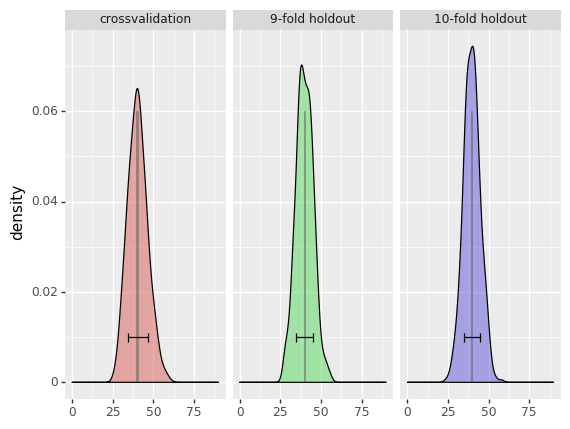

<ggplot: (-9223363245530296046)>

In [15]:
# Fix order for facets
from pandas.api.types import CategoricalDtype
MethodType = CategoricalDtype(['crossvalidation','9-fold holdout', '10-fold holdout'], ordered = True)
df = (result.loc[result['measure'] == 'test error', ['method', 'mean']]
      .rename(columns = {'mean': 'estimate'})
      .assign(method = lambda df: df['method'].astype(MethodType)))

# Estimate the standard deviation of mean for each method
sdf = (df.groupby('method')
       .aggregate(['mean', 'std'])
       .pipe(reset_column_index, 0)
       .reset_index()       
       .assign(lower_ci = lambda df: df['mean'] - 3 * df['std']/np.sqrt(r))
       .assign(upper_ci = lambda df: df['mean'] + 3 * df['std']/np.sqrt(r))
       .assign(mp_std = lambda df: df['mean'] + df['std'])
       .assign(mm_std = lambda df: df['mean'] - df['std'])
       .assign(y = 0.01))

display(sdf)

# Plot the distribution of estimated test error
p = ggplot(df)
p = p + geom_density(aes(x = 'estimate', fill = 'method'), alpha = 0.5)
p = p + facet_wrap('method')
p = p + scale_x_continuous(name = '', limits =(0, 90)) 
p = p + geom_rect(aes(xmin = 'lower_ci', xmax = 'upper_ci'), ymin = 0, ymax = 0.06, data = sdf, size = 0.25, alpha =0.5)
p = p + geom_errorbarh(aes(xmin='mm_std' , xmax = 'mp_std', y = 'y'), height = 0.002,  data = sdf)
p = p + scale_fill_discrete(guide=False)
p.save('crossvalidation_vs_holdout.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Visualisation of test error variance estimates

Compute the variance of all test error estimates and extract the cross-validation variance estimates. 

,std_estimate
crossvalidation,6.051159
9-fold holdout,5.251790
10-fold holdout,5.129870


,method,fold_std,std_estimate
3500,crossvalidation,20.110804,6.359595
3501,crossvalidation,12.292726,3.887301
3502,crossvalidation,16.363917,5.174725
3503,crossvalidation,18.257419,5.773503
3504,crossvalidation,8.432740,2.666667


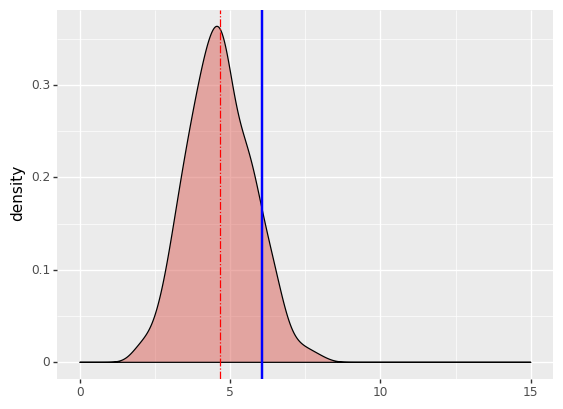

<ggplot: (-9223363245530295152)>

In [16]:
test_std = {}
test_std['crossvalidation'] = np.std(result.loc[(result['method'] == 'crossvalidation') & (result['measure'] == 'test error'), 'mean'])
test_std['9-fold holdout']  = np.std(result.loc[(result['method'] == '9-fold holdout')  & (result['measure'] == 'test error'), 'mean'])
test_std['10-fold holdout'] = np.std(result.loc[(result['method'] == '10-fold holdout') & (result['measure'] == 'test error'), 'mean'])

sdf = DataFrame(Series(test_std)).rename(columns = {0: 'std_estimate'})
display(sdf)

df = (result.loc[(result['method'] == 'crossvalidation') & (result['measure'] == 'test error'), ['method','std']]
      .assign(std_estimate = lambda df: df['std']/np.sqrt(10))
      .rename(columns = {'std': 'fold_std'})
      .assign(method = lambda df: df['method'].astype(MethodType)))
display(head(df))

p = ggplot(df)
p = p + geom_density(aes(x = 'std_estimate', fill = 'method'), alpha = 0.5)
p = p + geom_vline(xintercept = sdf.loc['crossvalidation', 'std_estimate'], linetype = '-', color= 'blue', size = 1)
p = p + geom_vline(xintercept = np.mean(df['std_estimate']), linetype = '-.', color= 'red')
p = p + scale_x_continuous(name = '', limits = (0, 15))
p = p + scale_fill_discrete(guide=False)
p.save('crossvalidation_variance_estimate.pdf', path='results', height=6, width=6, verbose=False)
display(p)

# Homework

## 4.1 Variance of the cross-validation estimate for different learning tasks (<font color='red'>1p</font>)  

The analysis of the cross-validation estimate fluctuations is incomplete in the notebook. 
* Extend the analysis so that all the dataset and learning algorithm pairs are covered.
* Draw the corresponding density plots with mean value and variance estimators.
* Draw the corresponding density plots for the naive cross-validation variance estimators.
* Try to see if there are significant differences in the mean and variance parameters.
* Display results in a $2\times2$ faceted plot where columns are for data sources and rows are for learning methods. 

## 4.2 Naive cross-validation variance estimate and dataset size* (<font color='red'>2p</font>)  

The analysis of the cross-validation estimate fluctuations is incomplete in the notebook as it does not consider how the variance estimate behaves on different dataset sizes. 
* Fix a data source `sampler_1` with signal to get meaningful results.
* Extend the analysis by considering different sizes of the dataset $N=10,20,\ldots, 100$.
* For each dataset size, estimate the mean value and standard deviation for the naive cross-validation variance estimator.
* For each dataset size, estimate the true value of the cross-validation variance and its standard deviation.
* Draw the error bar plot that contains both estimates for both learning algorithms.
* Interpret the results. 
  * Does the naive cross-validation variance estimate converges to true value?
  * Does the convergence speed depend on the learning algorithm?

In [17]:
%config IPCompleter.greedy=True